## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [1]:
import os
import keras

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [19]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
model = build_mlp(input_shape=x_train.shape[1:])

In [20]:
LEARNING_RATE = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = [0.7, 0.8, 0.9]

In [21]:
results = {}
for m in MOMENTUM:
    keras.backend.clear_session()
    print("Run with momentum = %.2f" %(m))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=m)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "momentum-%s" % str(m)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}    

Run with momentum = 0.70
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/5

50000/50000 [==============================] - 233s 5ms/step - loss: 0.7955 - acc: 0.7137 - val_loss: 2.0894 - val_acc: 0.4408
Run with momentum = 0.80
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
______________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 215s 4ms/step - loss: 2.1576 - acc: 0.1919 - val_loss: 2.0082 - val_acc: 0.2444
Epoch 2/50
50000/50000 [==============================] - 214s 4ms/step - loss: 1.9171 - acc: 0.2931 - val_loss: 1.8224 - val_acc: 0.3287
Epoch 3/50
50000/50000 [==============================] - 218s 4ms/step - loss: 1.8278 - acc: 0.3328 - val_loss: 1.8923 - val_acc: 0.3185
Epoch 4/50
50000/50000 [==============================] - 215s 4ms/step - loss: 1.7556 - acc: 0.3694 - val_loss: 1.7174 - val_acc: 0.3792
Epoch 5/50
50000/50000 [==============================] - 214s 4ms/step - loss: 1.6988 - acc: 0.3904 - val_loss: 1.8819 - val_acc: 0.3244
Epoch 6/50
50000/50000 [==============================] - 215s 4ms/step - loss: 1.6595 - acc: 0.4069 - val_loss: 1.7453 - val_acc: 0.3662
Epoch 7/50
50000/50000 [==============================] - 214s 4ms/step - loss: 1.6290 - acc: 0.4133 - val_loss: 1.8772 - 

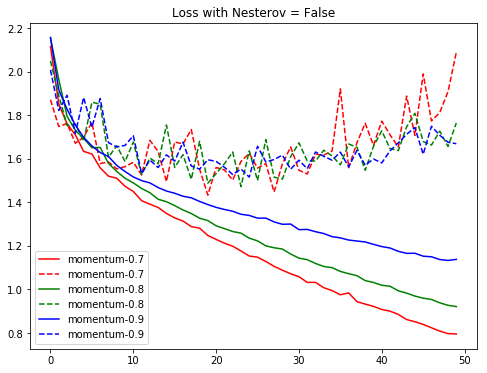

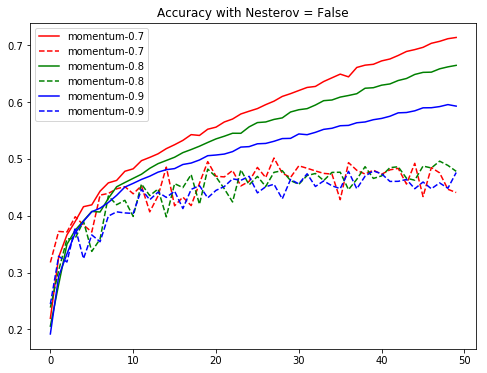

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['r', 'g', 'b', 'y', 'm', 'k']
plt.figure(figsize=(8,6))

for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss with Nesterov = False")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy with Nesterov = False")
plt.legend()
plt.show()